In [23]:
!pip install matplotlib
!pip install sklearn
!pip install tqdm
!pip install torch
!pip install torchvision
!pip install pandas
!pip install transformers

     |████████████████████████████████| 4.2 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 661 kB 96.8 MB/s eta 0:00:01
     |████████████████████████████████| 763 kB 68.9 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 56.8 MB/s eta 0:00:01


In [132]:
!nvidia-smi

/usr/bin/sh: 1: nvidia-smi: not found


In [138]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import json
import torch as t
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import torchvision.transforms as transforms
import random
import torchvision.models as models
import os
from torchvision.transforms.functional import to_tensor
import pandas as pd

seed = 42
np.random.seed(seed)
np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(False)

EPOCHS = 10
NUM_LAYERS_FROZEN = 6
lr = 2e-5
multitask_lr = 2e-4
C_constant = 100
data_saved_path = "../data"
current_model_path = 'model_shallow_simple_C_big_lr_' + str(NUM_LAYERS_FROZEN) + '_' + str(EPOCHS) + '_solved_bug'
save_path = os.path.join(data_saved_path, current_model_path)


In [196]:
class RoadsignDataset(Dataset):
  def __init__(self, roadsign_root, roadsign_annot, roadsign_imgs, roadsign_temp, feature_extractor, img_size=(224, 224), img_type="png"):
    """
    Args:
        dataset_lines (array): array of strings of form "{image_path}|{rectangle_coordinates}".
        width (int): target image width.
        height (int): target image height.
    """
    self.roadsign_root = roadsign_root
    self.roadsign_annot = roadsign_annot
    self.roadsign_imgs = roadsign_imgs
    self.feature_extractor = feature_extractor
    self.img_size = img_size
    self.img_type = img_type

    self.roadsign_annot_file = os.path.join(roadsign_root, roadsign_annot)
    self.roadsign_imgs_dir = os.path.join(roadsign_root, roadsign_imgs)
    self.roadsign_temp_dir = os.path.join(roadsign_root, roadsign_temp)
    
    with open(self.roadsign_annot_file) as infile:
        self.annot_data = json.load(infile)
    self.all_annot_types = self.annot_data['types']
    self.all_annotations = self.annot_data['imgs']

    self.init_dataset()

  def init_dataset(self):
    self.annotations_types = []
    for type in self.all_annot_types:
        full_path = os.path.join(self.roadsign_temp_dir, type + "." + self.img_type)
        if os.path.exists(full_path):
            self.annotations_types.append(type)
    print(self.annotations_types)
    self.annotations_to_id = {ann: idx for idx, ann in enumerate(self.annotations_types)}
    self.id_to_annotations = {idx: ann for ann, idx in self.annotations_to_id.items()}
    print(self.annotations_to_id)
    self.annotations = {}
    current_id = 0
    for key, item in self.all_annotations.items():
        for annot_data in item['objects']:
            if annot_data['category'] in self.annotations_types:
                self.annotations[current_id] = {
                    'path': item['path'].split("/")[1],
                    'id': current_id,
                    'object': annot_data
                }
                current_id += 1
    with open(os.path.join(self.roadsign_root, 'new_' + self.roadsign_annot), 'w') as outfile:
        json.dump({
        'types': self.annotations_types,
        'imgs': self.annotations
    }, outfile)

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, idx):
    ok = True
    data = self.annotations[idx]
    img_path = os.path.join(self.roadsign_imgs_dir, data['path'])
    
    use_other_template = np.random.rand()
    annotation = data['object']
    template_used = annotation['category']
    if use_other_template > 0.5:
        use_other_template = 1
        new_id = np.random.randint(len(self.annotations_types))
        while self.annotations_to_id[template_used] == new_id:
            new_id = np.random.randint(len(self.annotations_types))
        template_used = self.id_to_annotations[new_id]
        
    annotation_id = self.annotations_to_id[template_used]
    template_path = os.path.join(self.roadsign_temp_dir, template_used + "." + self.img_type)
    
    img = Image.open(img_path)
    temp = Image.open(template_path)
    if temp.mode == 'RGBA':
        temp = temp.convert('RGB')

    
    original_width, original_height = img.size
    similarity = -1 if use_other_template == 1 else 1

    img = img.resize(self.img_size, Image.Resampling.NEAREST)
    img = np.array(img)
    temp = temp.resize(self.img_size)
    temp = np.array(temp)

    # if len(img.shape) == 2:
    #   img = np.expand_dims(img, axis=2)
    #   img = np.repeat(img, 3, axis=2)
    # if len(temp.shape) == 2:
    #   temp = np.expand_dims(temp, axis=2)
    #   temp = np.repeat(temp, 3, axis=2)

    img = to_tensor(img)
    temp = to_tensor(temp)

    # temp = to_tensor(temp)
    # transform = transforms.Compose([
    #     transforms.RandomHorizontalFlip(),
    #     transforms.RandomVerticalFlip()
    #     # transforms.ToTensor()
    # ])
    # if random.random() < 0.5:
    # img = transform(img)
    # else:
    #     img = to_tensor(img)

    
    
    bbox = annotation['bbox'] 

    xmin = bbox['xmin']
    xmax = bbox['xmax']
    ymin = bbox['ymin']
    ymax = bbox['ymax']

    # x1 = x1 / original_width * self.img_size[0]
    # x2 = x2 / original_width * self.img_size[0]
    # y1 = y1 / original_height * self.img_size[1]
    # y2 = y2 / original_height * self.img_size[1]
    xmin = xmin / original_width
    xmax = xmax / original_width
    ymin = ymin / original_height
    ymax = ymax / original_height

    coordinates = np.array([xmin, ymin, xmax, ymax])
    coordinates = coordinates.astype(np.float32)
    
    if ok == False:
        processed_imgs = self.feature_extractor(img, return_tensors='pt')
        processed_temps = self.feature_extractor(temp, return_tensors='pt')

        return np.array(processed_imgs['pixel_values']).squeeze(), np.array(processed_temps['pixel_values']).squeeze(), similarity, coordinates
    return img, temp, similarity, coordinates


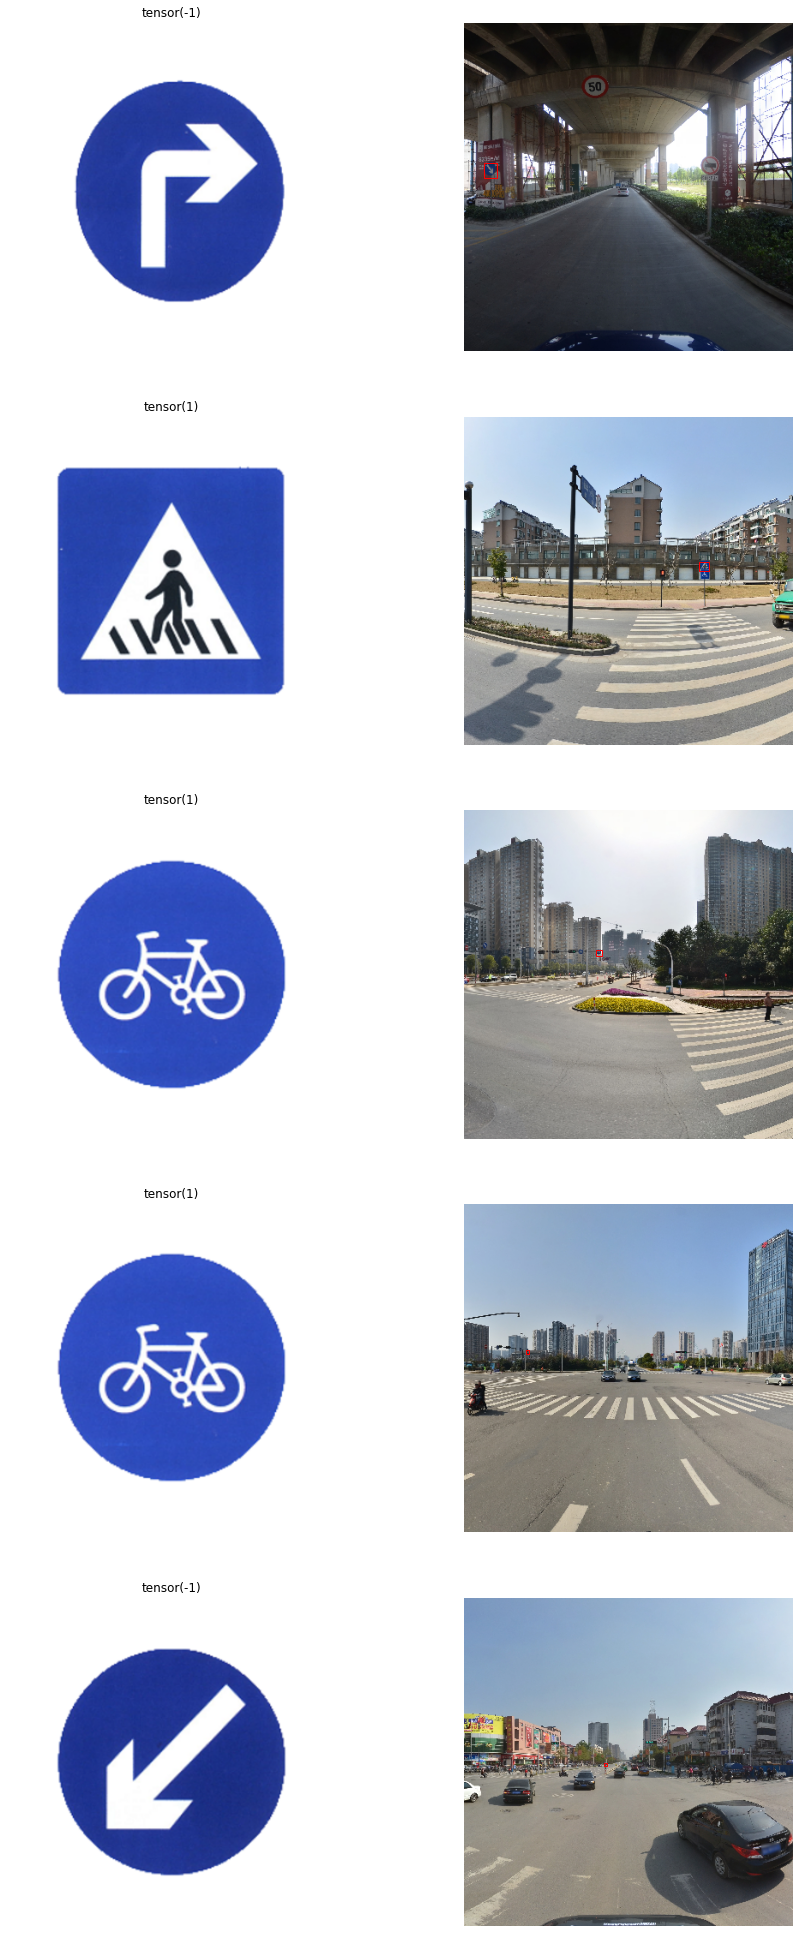

In [198]:
from IPython.display import clear_output
import time
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-384')

roadsign_root = "./data/data-roadsign"
roadsign_anno_train = "annotations_all.json"
roadsign_imgs_train = "images"
roadsign_temp_train = "marks"

# coco_anno_valid = os.path.join(coco_root, "data/valid/_annotations.coco.json")
# coco_imgs_valid = os.path.join(coco_root, "data/valid")

batch_train = 6
batch_valid = 1

dataset_train = RoadsignDataset(roadsign_root, roadsign_anno_train, roadsign_imgs_train, roadsign_temp_train, feature_extractor, img_size=(384, 384))
train_dataloader = DataLoader(dataset_train, batch_size=batch_train, shuffle=True, num_workers=1)

# dataset_valid = HandsDataset(coco_root, coco_anno_valid, coco_imgs_valid, feature_extractor, img_size=(224, 224))
# valid_dataloader = DataLoader(dataset_valid, batch_size=batch_valid, shuffle=False, num_workers=1)

see_examples = 5
fig = plt.figure(figsize=(15, 7*see_examples))
for i, (imgs, templates, similarity, coordinates) in enumerate(train_dataloader):
    clear_output(wait=True)
    imgs = np.transpose(imgs, (0, 2, 3, 1))
    templates = np.transpose(templates, (0, 2, 3, 1))
    fig.add_subplot(see_examples, 2, i * 2 + 1)
    plt.title(similarity[0])
    plt.axis('off')
    plt.imshow(templates[0])
   
    fig.add_subplot(see_examples, 2, i * 2 + 2)
    
    plt.axis('off')
    plt.imshow(imgs[0])
    
    

    x1, y1, x2, y2 = coordinates[0]
    x1 = x1 * dataset_train.img_size[1]
    y1 = y1 * dataset_train.img_size[0]
    x2 = x2 * dataset_train.img_size[1]
    y2 = y2 * dataset_train.img_size[0]

    rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    

    if i >= see_examples - 1:
      break
plt.show()

In [131]:
# categories = dataset_train.coco.loadCats(dataset_train.coco.getCatIds())
category2id = dataset_train.annotations_to_id
id2category = dataset_train.id_to_annotations
print(category2id)
print(id2category)

{'i8': 0, 'ip': 1, 'i4': 2, 'i14': 3, 'i11': 4, 'i9': 5, 'i15': 6, 'i1': 7, 'i12': 8, 'i10': 9, 'i13': 10, 'il50': 11, 'i6': 12, 'i2': 13, 'i7': 14, 'i5': 15, 'i3': 16}
{0: 'i8', 1: 'ip', 2: 'i4', 3: 'i14', 4: 'i11', 5: 'i9', 6: 'i15', 7: 'i1', 8: 'i12', 9: 'i10', 10: 'i13', 11: 'il50', 12: 'i6', 13: 'i2', 14: 'i7', 15: 'i5', 16: 'i3'}


In [136]:
from transformers import ViTForImageClassification, ViTConfig, ViTModel

# vit_config = ViTConfig(hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5)

# vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
#                                                       num_labels=len(category2id),
#                                                       id2label=id2category,
#                                                       label2id=category2id)
vit_backbone_image = ViTModel.from_pretrained('google/vit-base-patch16-384')
# vit_backbone_template = ViTModel.from_pretrained('google/vit-base-patch16-384')

for param in vit_backbone_image.embeddings.parameters():
    param.requires_grad = False
for layer in vit_backbone_image.encoder.layer[:NUM_LAYERS_FROZEN]:
    print(layer)
    for param in layer.parameters():
        param.requires_grad = False
        
# for param in vit_backbone_template.embeddings.parameters():
#     param.requires_grad = False
# for layer in vit_backbone_template.encoder.layer[:NUM_LAYERS_FROZEN]:
#     print(layer)
#     for param in layer.parameters():
#         param.requires_grad = False

# print(vit_model)
# print(vars(vit_backbone))

class SiameseTransformerViT(nn.Module):
    def __init__(self, backbone_image):
        super(SiameseTransformerViT, self).__init__()
        self.backbone_image = backbone_image
        # self.backbone_template = backbone_template
    
        self.bounding_box = nn.Sequential(
            nn.Linear(backbone_image.config.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 4),
        )
    def forward_once(self, x):
        x = self.backbone_image(x)
        x = x.last_hidden_state[:, 0, :]
        return x
        

    def forward(self, image, template):
        image_features = self.forward_once(image)
        template_features = self.forward_once(template)
        similarity = nn.Functional.cosine_similarity(image_features, template_features)
        bbox_prediction = self.bounding_box(torch.cat([image_features, template_features], 1))
        # features = features.last_hidden_state[:, 0, :]
        # print(features[:, 0, :].shape)
        return image_features, template_features, similarity, bbox_prediction

ViTModel = SiameseTransformerViT(vit_backbone_image)


Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTLayer(
  (attention): ViTAttention(
    (attention): ViTSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (output): ViTSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (intermediate): ViTIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): ViTOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)
ViTLayer(
  (attention): ViTAttention(
    (attention): ViTSelfAttention(
 

In [6]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    num_batches = len(train_dataloader)
    predictions = []
    labels = []
    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_images, batch_templates, batch_similarities, batch_bboxs = batch
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        raw_output = model(batch_images)
        loss, output = raw_output.loss, raw_output['logits']
        batch_predictions = torch.argmax(output, dim=1)

        loss = loss_crt(output, batch_labels)

        batch_acc = accuracy_score(batch_labels.cpu().numpy(), batch_predictions.cpu().numpy())
        epoch_acc += batch_acc

        loss_scalar = loss.item()

        # if idx % 150 == 0:
        #     print(epoch_acc/(idx + 1))
        #     print(batch_predictions)

        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=1.5
        )

        model.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss_scalar
        labels += batch_labels
        predictions += batch_predictions

    epoch_loss = epoch_loss/num_batches
    epoch_acc = epoch_acc/num_batches

    return epoch_loss, epoch_acc, labels, predictions


def eval_epoch(model, val_dataloader, loss_crt, device):
    model.eval()
    epoch_loss = 0.0
    epoch_acc = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(val_dataloader)):
            batch_images, batch_coords, batch_labels = batch
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            raw_output = model(batch_images)
            loss, output = raw_output.loss, raw_output['logits']
            batch_predictions = torch.argmax(output, dim=1)

            loss = loss_crt(output, batch_labels)

            batch_acc = accuracy_score(batch_labels.cpu().numpy(), batch_predictions.cpu().numpy())
            epoch_acc += batch_acc

            loss_scalar = loss.item()

            epoch_loss += loss_scalar
            labels += batch_labels
            predictions += batch_predictions

    epoch_loss = epoch_loss/num_batches
    epoch_acc = epoch_acc/num_batches

    return epoch_loss, epoch_acc, labels, predictions


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# move the model to GPU (when available)
vit_model.to(device)

# create a SGD optimizer
optimizer = torch.optim.AdamW(vit_model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(vit_model.parameters(), lr=1e-3, momentum=0.9)
# optimizer = torch.optim.Adam(vit_model.parameters(), lr=2e-5)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, threshold=1e-2, verbose=True)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
#
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, threshold=1e-3, verbose=True)

# set up loss function
loss_criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(1, EPOCHS+1):
    train_loss, train_accuracy, _, _ = train_epoch(vit_model, train_dataloader, loss_criterion, optimizer, device)
    val_loss, val_accuracy, _, _ = eval_epoch(vit_model, valid_dataloader, loss_criterion, device)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print('\nEpoch %d'%(epoch))
    print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
    print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))


252it [00:30,  8.22it/s]
144it [00:02, 63.76it/s]


Epoch 1
train loss: 3.05863740, accuracy: 0.26719577
val loss: 2.84091292, accuracy: 0.29861111



252it [00:30,  8.18it/s]
144it [00:02, 66.20it/s]


Epoch 2
train loss: 2.37149665, accuracy: 0.71097884
val loss: 2.28650603, accuracy: 0.62500000



252it [00:30,  8.16it/s]
144it [00:02, 64.34it/s]


Epoch 3
train loss: 1.74748080, accuracy: 0.91732804
val loss: 1.80850824, accuracy: 0.77083333



252it [00:30,  8.15it/s]
144it [00:02, 66.34it/s]


Epoch 4
train loss: 1.24567840, accuracy: 0.98214286
val loss: 1.45838932, accuracy: 0.82638889



252it [00:30,  8.19it/s]
144it [00:02, 66.19it/s]


Epoch 5
train loss: 0.86210619, accuracy: 0.99669312
val loss: 1.16112227, accuracy: 0.85416667



252it [00:30,  8.19it/s]
144it [00:02, 65.53it/s]


Epoch 6
train loss: 0.59591344, accuracy: 1.00000000
val loss: 0.94809012, accuracy: 0.85416667



252it [00:30,  8.18it/s]
144it [00:02, 66.91it/s]


Epoch 7
train loss: 0.42178206, accuracy: 1.00000000
val loss: 0.80194996, accuracy: 0.89583333



252it [00:30,  8.18it/s]
144it [00:02, 66.54it/s]


Epoch 8
train loss: 0.30976735, accuracy: 1.00000000
val loss: 0.68897292, accuracy: 0.88888889



252it [00:30,  8.18it/s]
144it [00:02, 66.80it/s]


Epoch 9
train loss: 0.23485414, accuracy: 1.00000000
val loss: 0.61535845, accuracy: 0.89583333



252it [00:30,  8.19it/s]
144it [00:02, 66.35it/s]


Epoch 10
train loss: 0.18306430, accuracy: 1.00000000
val loss: 0.56554888, accuracy: 0.88888889


In [15]:
current_model_path = 'simple_model_base_' + str(NUM_LAYERS_FROZEN) + '_' + str(EPOCHS)
save_path = os.path.join(data_saved_path, current_model_path)
try:
    os.makedirs(save_path)
except:
    print("Directory already exists")


In [16]:
# save model
torch.save(vit_model.state_dict(), os.path.join(save_path, "base_model_weights.pt"))


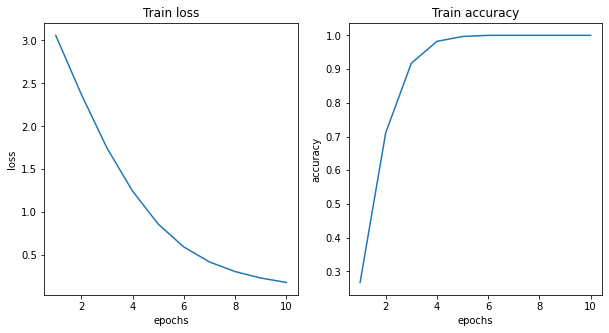

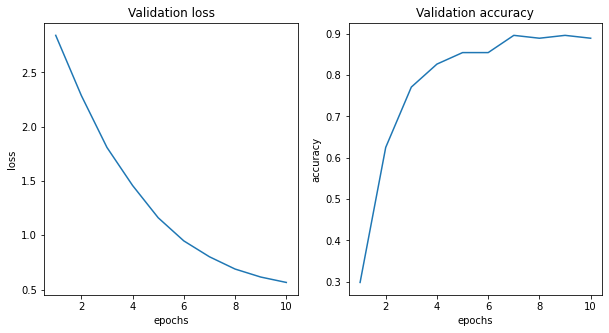

In [50]:
# train plots
epoch_list = np.arange(1, EPOCHS + 1, 1)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(epoch_list, train_losses)
axs[0].set_title('Train loss')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[1].plot(epoch_list, train_accuracies)
axs[1].set_title('Train accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
plt.subplots_adjust(wspace=0.2)
plt.savefig(os.path.join(save_path, 'base_train_plots.png'))
plt.show()

# val plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(epoch_list, val_losses)
axs[0].set_title('Validation loss')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[1].plot(epoch_list, val_accuracies)
axs[1].set_title('Validation accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
plt.subplots_adjust(wspace=0.2)
plt.savefig(os.path.join(save_path, 'base_validation_plots.png'))
plt.show()


In [60]:
base_data_dataframe = pd.DataFrame({
    'epochs': epoch_list,
    'train_acc': train_accuracies,
    'train_loss': train_losses,
    'val_acc': val_accuracies,
    'val_loss': val_losses
})
base_data_dataframe.to_csv(os.path.join(save_path, "train_data.csv"))


In [6]:
def calculate_iou_acc(iou_list, counter):
    iou_list_50 = (iou_list > 0.5).sum()
    iou_list_75 = (iou_list > 0.75).sum()
    iou_list_90 = (iou_list > 0.90).sum()
    return [iou_list_50 / counter, iou_list_75 / counter, iou_list_90 / counter]

def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def train_epoch_multi(model, train_dataloader, loss_classification, loss_bounding_box, optimizer, device, C):
    model.train()
    epoch_loss = 0.0
    class_acc = 0.0
    num_batches = len(train_dataloader)
    IOU_list = []
    predictions = []
    labels = []
    for idx, batch in tqdm(enumerate(train_dataloader)):
        batch_images, batch_coords, batch_labels = batch
        batch_images = batch_images.to(device)
        batch_coords = batch_coords.to(device)
        batch_labels = batch_labels.to(device)

        classification_output, bbox_output = model(batch_images)
        batch_predictions = torch.argmax(classification_output, dim=1)

        class_loss = loss_classification(classification_output, batch_labels)
        bbox_loss = loss_bounding_box(bbox_output, batch_coords)
        # print("Classification loss:")
        # print(class_loss)
        # print("Bounding box loss:")
        # print(bbox_loss)
        loss = class_loss / C + bbox_loss

        model.zero_grad()
        loss.backward()
        optimizer.step()

        batch_acc = accuracy_score(batch_labels.cpu().numpy(), batch_predictions.cpu().numpy())
        class_acc += batch_acc

        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=1.5
        )

        loss_scalar = loss.item()
        epoch_loss += loss_scalar
        labels += batch_labels
        predictions += batch_predictions
        bbox_pred = bbox_output.detach().cpu().numpy()
        bbox_original = batch_coords.cpu().numpy()

        IOU_list.append(bb_intersection_over_union(bbox_pred[0], bbox_original[0]))

    epoch_loss = epoch_loss/num_batches
    epoch_acc = class_acc/num_batches
    IOU_list = np.array(IOU_list)

    return epoch_loss, epoch_acc, IOU_list, labels, predictions


def eval_epoch_multi(model, val_dataloader, loss_classification, loss_bounding_box, device):
    model.eval()
    epoch_loss = 0.0
    epoch_acc = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    IOU_list = []
    labels = []
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(val_dataloader)):
            batch_images, batch_coords, batch_labels = batch
            batch_images = batch_images.to(device)
            batch_coords = batch_coords.to(device)
            batch_labels = batch_labels.to(device)

            classification_output, bbox_output = model(batch_images)
            batch_predictions = torch.argmax(classification_output, dim=1)

            class_loss = loss_classification(classification_output, batch_labels)
            bbox_loss = loss_bounding_box(bbox_output, batch_coords)
            loss = class_loss + bbox_loss

            batch_acc = accuracy_score(batch_labels.cpu().numpy(), batch_predictions.cpu().numpy())
            epoch_acc += batch_acc

            loss_scalar = loss.item()

            epoch_loss += loss_scalar
            labels += batch_labels
            predictions += batch_predictions
            bbox_pred = bbox_output.detach().cpu().numpy()
            bbox_original = batch_coords.cpu().numpy()

            IOU_list.append(bb_intersection_over_union(bbox_pred[0], bbox_original[0]))

    epoch_loss = epoch_loss/num_batches
    epoch_acc = epoch_acc/num_batches
    IOU_list = np.array(IOU_list)

    return epoch_loss, epoch_acc, IOU_list, labels, predictions

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# move model to device
multitask_model.to(device)

# create the optimizer
optimizer = torch.optim.AdamW(multitask_model.parameters(), lr=multitask_lr)
# optimizer = torch.optim.SGD(vit_model.parameters(), lr=1e-3, momentum=0.9)
# optimizer = torch.optim.Adam(vit_model.parameters(), lr=2e-5)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, threshold=1e-2, verbose=True)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
#
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, threshold=1e-3, verbose=True)

# set up loss function
loss_classification = nn.CrossEntropyLoss()
loss_bounding = nn.MSELoss()

train_losses = []
train_accuracies = []
train_iou = []
val_losses = []
val_accuracies = []
val_iou =[]
for epoch in range(1, EPOCHS+1):
    train_loss, train_accuracy, train_IOU_data, _, _ = train_epoch_multi(multitask_model, train_dataloader, loss_classification, loss_bounding, optimizer, device, C_constant)
    val_loss, val_accuracy, val_IOU_data, _, _ = eval_epoch_multi(multitask_model, valid_dataloader, loss_classification, loss_bounding, device)
    scheduler.step(val_loss)
    train_IOU_data = calculate_iou_acc(train_IOU_data, len(train_dataloader))
    val_IOU_data = calculate_iou_acc(val_IOU_data, len(valid_dataloader))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_iou.append(train_IOU_data)
    val_iou.append(val_IOU_data)
    print('\nEpoch %d'%(epoch))
    print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
    print(f"train IOU 50% accuracy: {train_IOU_data[0]}")
    print(f"train IOU 75% accuracy: {train_IOU_data[1]}")
    print(f"train IOU 90% accuracy: {train_IOU_data[2]}")
    print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))
    print(f"val IOU 50% accuracy: {val_IOU_data[0]}")
    print(f"val IOU 75% accuracy: {val_IOU_data[1]}")
    print(f"val IOU 90% accuracy: {val_IOU_data[2]}")


252it [00:31,  7.92it/s]
144it [00:02, 63.86it/s]


Epoch 1
train loss: 0.04818957, accuracy: 0.10912698
train IOU 50% accuracy: 0.9920634920634921
train IOU 75% accuracy: 0.7182539682539683
train IOU 90% accuracy: 0.10714285714285714
val loss: 2.96339825, accuracy: 0.10416667
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.9027777777777778
val IOU 90% accuracy: 0.1875



252it [00:31,  7.89it/s]
144it [00:02, 64.42it/s]


Epoch 2
train loss: 0.03165657, accuracy: 0.32870370
train IOU 50% accuracy: 0.996031746031746
train IOU 75% accuracy: 0.8611111111111112
train IOU 90% accuracy: 0.1865079365079365
val loss: 1.86524106, accuracy: 0.31944444
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.9513888888888888
val IOU 90% accuracy: 0.24305555555555555



252it [00:32,  7.82it/s]
144it [00:02, 63.36it/s]


Epoch 3
train loss: 0.01755051, accuracy: 0.66798942
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.9523809523809523
train IOU 90% accuracy: 0.2222222222222222
val loss: 0.97747803, accuracy: 0.67361111
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.9097222222222222
val IOU 90% accuracy: 0.3819444444444444



252it [00:32,  7.82it/s]
144it [00:02, 62.98it/s]


Epoch 4
train loss: 0.00908718, accuracy: 0.91732804
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.9722222222222222
train IOU 90% accuracy: 0.3253968253968254
val loss: 0.51907983, accuracy: 0.83333333
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.9722222222222222
val IOU 90% accuracy: 0.2916666666666667



252it [00:32,  7.86it/s]
144it [00:02, 67.53it/s]


Epoch 5
train loss: 0.00548609, accuracy: 0.97420635
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.9841269841269841
train IOU 90% accuracy: 0.31746031746031744
val loss: 0.42121094, accuracy: 0.86111111
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.9861111111111112
val IOU 90% accuracy: 0.3680555555555556



252it [00:31,  7.88it/s]
144it [00:02, 66.74it/s]


Epoch 6
train loss: 0.00405201, accuracy: 0.99669312
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.9801587301587301
train IOU 90% accuracy: 0.3968253968253968
val loss: 0.35437025, accuracy: 0.88888889
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.9791666666666666
val IOU 90% accuracy: 0.4166666666666667



252it [00:31,  7.88it/s]
144it [00:02, 66.30it/s]



Epoch 7
train loss: 0.00382732, accuracy: 0.99933862
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.9722222222222222
train IOU 90% accuracy: 0.47619047619047616
val loss: 0.37461603, accuracy: 0.87500000
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.9861111111111112
val IOU 90% accuracy: 0.5138888888888888


252it [00:32,  7.86it/s]
144it [00:02, 63.04it/s]

Epoch     8: reducing learning rate of group 0 to 2.0000e-05.

Epoch 8
train loss: 0.00340032, accuracy: 0.99801587
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.9920634920634921
train IOU 90% accuracy: 0.5555555555555556
val loss: 0.39764149, accuracy: 0.84027778
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 1.0
val IOU 90% accuracy: 0.5277777777777778



252it [00:32,  7.86it/s]
144it [00:02, 64.12it/s]


Epoch 9
train loss: 0.00234701, accuracy: 1.00000000
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 0.996031746031746
train IOU 90% accuracy: 0.7142857142857143
val loss: 0.36245980, accuracy: 0.87500000
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.9930555555555556
val IOU 90% accuracy: 0.6527777777777778



252it [00:32,  7.85it/s]
144it [00:02, 66.10it/s]

Epoch    10: reducing learning rate of group 0 to 2.0000e-06.

Epoch 10
train loss: 0.00191759, accuracy: 1.00000000
train IOU 50% accuracy: 1.0
train IOU 75% accuracy: 1.0
train IOU 90% accuracy: 0.753968253968254
val loss: 0.35497040, accuracy: 0.88194444
val IOU 50% accuracy: 1.0
val IOU 75% accuracy: 0.9930555555555556
val IOU 90% accuracy: 0.6597222222222222


In [8]:
try:
    os.makedirs(save_path)
except:
    print("Directory already exists")


In [9]:
# save model
torch.save(multitask_model.state_dict(), os.path.join(save_path, "model_weights.pt"))


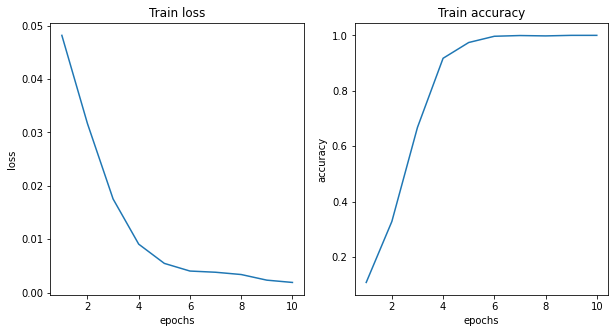

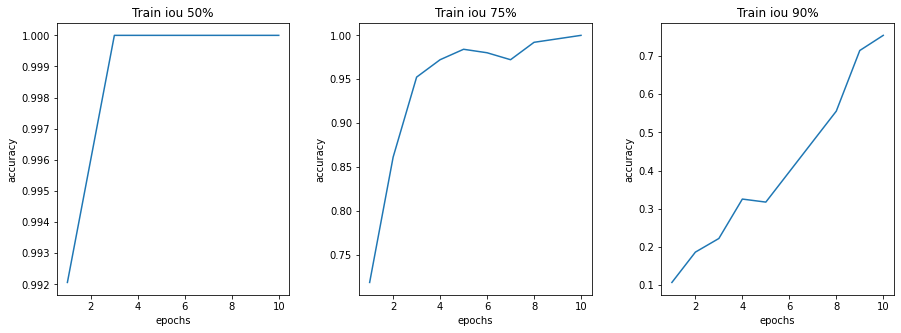

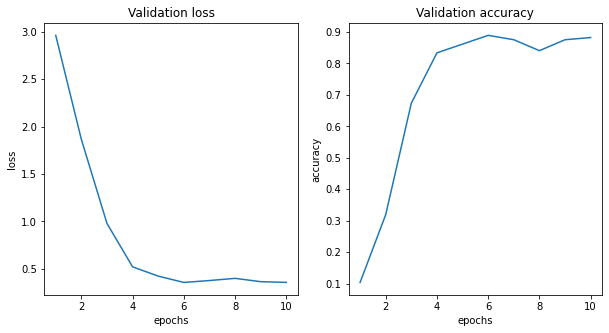

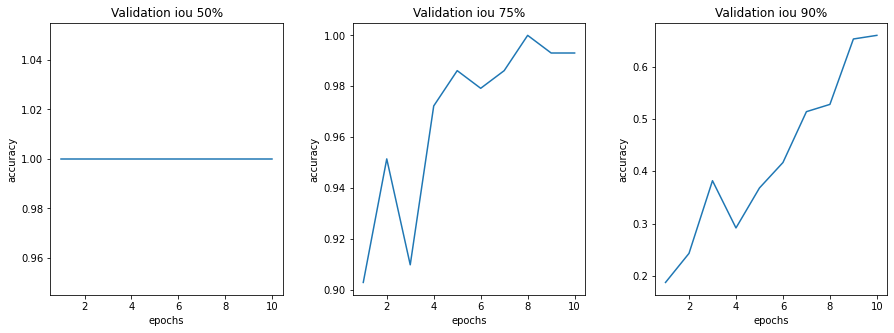

In [10]:
# TODO: Add all plots for data
# train plots
epoch_list = np.arange(1, EPOCHS + 1, 1)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(epoch_list, train_losses)
axs[0].set_title('Train loss')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[1].plot(epoch_list, train_accuracies)
axs[1].set_title('Train accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
plt.subplots_adjust(wspace=0.2)
plt.savefig(os.path.join(save_path, 'train_plots.png'))
plt.show()

train_iou = np.array(train_iou)
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(epoch_list, train_iou[:, 0])
axs[0].set_title('Train iou 50%')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[1].plot(epoch_list, train_iou[:, 1])
axs[1].set_title('Train iou 75%')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[2].plot(epoch_list, train_iou[:, 2])
axs[2].set_title('Train iou 90%')
axs[2].set_xlabel('epochs')
axs[2].set_ylabel('accuracy')
plt.subplots_adjust(wspace=0.3)
plt.savefig(os.path.join(save_path, 'train_iou.png'))
plt.show()

# val plots
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(epoch_list, val_losses)
axs[0].set_title('Validation loss')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[1].plot(epoch_list, val_accuracies)
axs[1].set_title('Validation accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
plt.subplots_adjust(wspace=0.2)
plt.savefig(os.path.join(save_path, 'validation_plots.png'))
plt.show()

val_iou = np.array(val_iou)
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].plot(epoch_list, val_iou[:, 0])
axs[0].set_title('Validation iou 50%')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[1].plot(epoch_list, val_iou[:, 1])
axs[1].set_title('Validation iou 75%')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[2].plot(epoch_list, val_iou[:, 2])
axs[2].set_title('Validation iou 90%')
axs[2].set_xlabel('epochs')
axs[2].set_ylabel('accuracy')
plt.subplots_adjust(wspace=0.3)
plt.savefig(os.path.join(save_path, 'validation_iou.png'))
plt.show()

In [11]:
data_dataframe = pd.DataFrame({
    'epochs': epoch_list,
    'train_acc': train_accuracies,
    'train_loss': train_losses,
    'train_iou_50%': train_iou[:, 0],
    'train_iou_75%': train_iou[:, 1],
    'train_iou_90%': train_iou[:, 2],
    'val_acc': val_accuracies,
    'val_loss': val_losses,
    'val_iou_50%': val_iou[:, 0],
    'val_iou_75%': val_iou[:, 1],
    'val_iou_90%': val_iou[:, 2]
})
data_dataframe.to_csv(os.path.join(save_path, "training_data.csv"))
